## Project Details | Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines

Can you predict whether people got H1N1 and seasonal flu vaccines using information they shared about their backgrounds, opinions, and health behaviors?

Our goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, we are to be predicting two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.
It is a multi-label classification problem.

—---------------------------------------

Project description and files are from [Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/)

## Submission Format

From DrivenData problem statement:
The format for the submission .csv file is three columns: respondent_id, h1n1_vaccine, and seasonal_vaccine.

The predictions for the two target variables should be *float* (`float64`) **probabilities** that range between `0.0` and `1.0`. We need to build a model to predict two numeric probabilities for these target variables:



*   `h1n1_vaccine`
*   `seasonal_vaccine`



Because the competition uses `ROC AUC` as its evaluation metric, the values you submit must be the **probabilities that a person received each vaccine**, not binary labels.

As this is a multilabel problem, the probabilities for each row do not need to sum to one.

Binary labels are provided in the `training_set_labels` dataset. The labels are the values we need to predict. The `training_set_features` dataset has the features, the independent variables used to predict the probability.

## Import Modules

In [4]:
# install required packages
!pip install scikit-multilearn

In [5]:
# import libraries

# Common libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Feature Selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

# Libraries for Problem Transformation

from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

# Libraries for model training

from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score

# ML Pkgs

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss,classification_report

# Libraries for algorithm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

### Split Dataset into Train and Text

from sklearn.model_selection import train_test_split
# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Multi Label Pkgs

from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN

# Libraries for testing

from sklearn.metrics import accuracy_score , classification_report

# Removing warnings

import warnings
warnings.filterwarnings('ignore')

# Storing plots

%matplotlib inline

# Data Extraction - fetch the data from the source

Importing and loading the dataset into the dataframe

In [6]:
# The respondent_id is the unique identifier
features = pd.read_csv('/content/training_set_features.csv', index_col="respondent_id")
labels = pd.read_csv('/content/training_set_labels.csv', index_col="respondent_id")
data = features.join(labels)

Exploratory Data Analysis & Dimensions of the data

In [7]:
features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [8]:
labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [9]:
features.shape

(26707, 35)

In [10]:
labels.shape

(26707, 2)

Each row corresponding to the repondent_id is a survey respondent, with the columns being each feature. So we have 35 features and 26,707 reponses. From our labels dataset, we have our 2 target variables.

In [11]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
h1n1_concern,26615.0,1.618486,0.910311,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,26591.0,1.262532,0.618149,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,26636.0,0.048844,0.215545,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,26499.0,0.725612,0.446214,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,26688.0,0.068982,0.253429,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,26665.0,0.825614,0.379448,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,26620.0,0.358640,0.479610,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,26625.0,0.337315,0.472802,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,26579.0,0.677264,0.467531,0.0,0.0,1.0,1.0,1.0
doctor_recc_h1n1,24547.0,0.220312,0.414466,0.0,0.0,0.0,0.0,1.0


In [13]:
data.shape

(26707, 37)

What are the data types of each feature?

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

We will need to encode the features with `object` data type into `int` data types

# Explore the data for target variables

What does the distribution between the two target variables look like?
In this dataset: `0 = not received vaccine` & `1 = received the vaccine`

In [15]:
labels['h1n1_vaccine'].value_counts()

,count
h1n1_vaccine,
0,21033
1,5674


In [16]:
h1n1_counts = labels['h1n1_vaccine'].value_counts()
total_h1n1 = h1n1_counts[0] + h1n1_counts[1]
false_h1n1_percentage = (h1n1_counts[0] / total_h1n1) * 100
true_h1n1_percentage = (h1n1_counts[1] / total_h1n1) * 100
print(f"Percentage who had taken the H1N1 vaccine: {true_h1n1_percentage}")
print(f"Percentage who had not taken the H1N1 vaccine: {false_h1n1_percentage}")

Percentage who had taken the H1N1 vaccine: 21.24536638334519
Percentage who had not taken the H1N1 vaccine: 78.75463361665481


In [17]:
labels['seasonal_vaccine'].value_counts()

,count
seasonal_vaccine,
0,14272
1,12435


In [18]:
seasonal_counts = labels['seasonal_vaccine'].value_counts()
total_seasonal = seasonal_counts[0] + seasonal_counts[1]
false_seasonal_percentage = (seasonal_counts[0] / total_seasonal) * 100
true_seasonal_percentage = (seasonal_counts[1] / total_seasonal) * 100
print(f"Percentage who had taken the seasonal flu vaccine: {true_seasonal_percentage}")
print(f"Percentage who had not taken the seasonal vaccine: {false_seasonal_percentage}")

Percentage who had taken the seasonal flu vaccine: 46.56082674954132
Percentage who had not taken the seasonal vaccine: 53.43917325045868


<Axes: xlabel='h1n1_vaccine'>

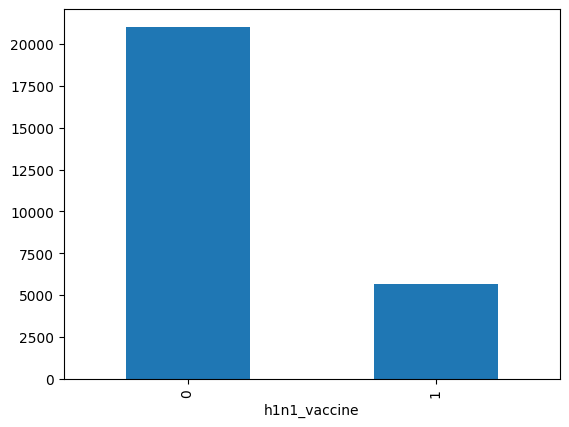

In [19]:
h1n1_counts.plot(kind="bar")

<Axes: xlabel='seasonal_vaccine'>

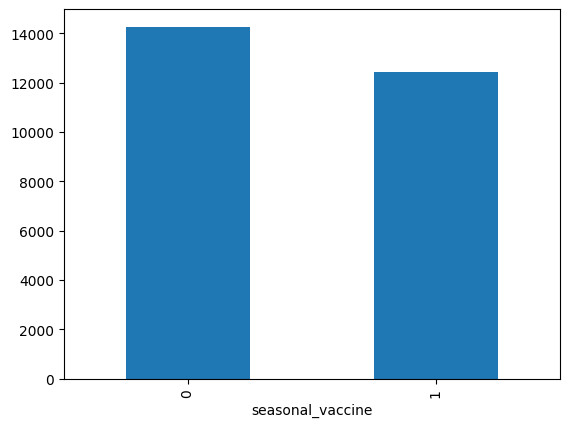

In [20]:
seasonal_counts.plot(kind="bar")

So for the seasonal vaccine, around ~46% people received it. For the H1N1 vaccine, only around ~21% people have recieved it. Classes are imbalanced for the H1N1 target class.

Do the vaccines influence each other? If one vaccine is received, was the other vaccine also received?

In [21]:
pd.crosstab(
    labels["h1n1_vaccine"],
    labels["seasonal_vaccine"],
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


Looks like, the people who got the H1N1 vaccine -> most also got the seasonal vaccine.

The people who got the seasonal vaccine -> more did not get the H1N1 vaccine.

However, people who did not get the seasonal vaccine, more than likely also did not get the H1N1 vaccine.

# Data Clean-up for the Features

Any missing values in dataset?

In [22]:
data.isnull().sum()/ len(data)*100

,0
h1n1_concern,0.344479
h1n1_knowledge,0.434343
behavioral_antiviral_meds,0.265848
behavioral_avoidance,0.778822
behavioral_face_mask,0.071142
behavioral_wash_hands,0.157262
behavioral_large_gatherings,0.325757
behavioral_outside_home,0.307036
behavioral_touch_face,0.479275
doctor_recc_h1n1,8.087767


In [23]:
features.isnull().sum()

,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82
behavioral_touch_face,128
doctor_recc_h1n1,2160


In [24]:
features.isnull().sum()/ len(data)*100

,0
h1n1_concern,0.344479
h1n1_knowledge,0.434343
behavioral_antiviral_meds,0.265848
behavioral_avoidance,0.778822
behavioral_face_mask,0.071142
behavioral_wash_hands,0.157262
behavioral_large_gatherings,0.325757
behavioral_outside_home,0.307036
behavioral_touch_face,0.479275
doctor_recc_h1n1,8.087767


In [25]:
# Check for not a number values
nan_count_per_column = features.isna().sum()

total_nan_count = features.isna().sum().sum()
print(total_nan_count)

60762


The columns with the most missing values include: employment_occupation, employment_industry, health_insurance, and income_poverty. These are features that survey participants did not want to answer.

Check for duplicate data in dataset

In [26]:
data.duplicated().sum()

0

No duplicate data in dataset

Unique values for features

In [27]:
for column in data.columns:
    if data[column].dtype == 'object':
        print(column.upper(),': ',data[column].nunique())
        print(data[column].value_counts().sort_values())
        print('\n')

AGE_GROUP :  5
age_group
35 - 44 Years    3848
18 - 34 Years    5215
45 - 54 Years    5238
55 - 64 Years    5563
65+ Years        6843
Name: count, dtype: int64


EDUCATION :  4
education
< 12 Years           2363
12 Years             5797
Some College         7043
College Graduate    10097
Name: count, dtype: int64


RACE :  4
race
Other or Multiple     1612
Hispanic              1755
Black                 2118
White                21222
Name: count, dtype: int64


SEX :  2
sex
Male      10849
Female    15858
Name: count, dtype: int64


INCOME_POVERTY :  3
income_poverty
Below Poverty                 2697
> $75,000                     6810
<= $75,000, Above Poverty    12777
Name: count, dtype: int64


MARITAL_STATUS :  2
marital_status
Not Married    11744
Married        13555
Name: count, dtype: int64


RENT_OR_OWN :  2
rent_or_own
Rent     5929
Own     18736
Name: count, dtype: int64


EMPLOYMENT_STATUS :  3
employment_status
Unemployed             1453
Not in Labor Force    10231
E

Make 2 lists, one for catergorical and one for numerical If data type is object -> category, else numerical

In [28]:
cat=[]
num=[]
for i in data.columns:
    if data[i].dtype=="object":
        cat.append(i)
    else:
        num.append(i)
print(cat)
print(num)

['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children', 'h1n1_vaccine', 'seasonal_vaccine']


### Encoding the `object` data type into an `int` data type

In [29]:
enc = LabelEncoder()

For combined data frame:

In [30]:
#data.age_group = enc.fit_transform(data.age_group)
#data.education = enc.fit_transform(data.education)
#data.race = enc.fit_transform(data.race)
#data.sex = enc.fit_transform(data.sex)
#data.income_poverty = enc.fit_transform(data.income_poverty)
data.marital_status = enc.fit_transform(data.marital_status)
data.rent_or_own = enc.fit_transform(data.rent_or_own)
#data.employment_status = enc.fit_transform(data.employment_status)
data.hhs_geo_region = enc.fit_transform(data.hhs_geo_region)
data.census_msa = enc.fit_transform(data.census_msa)
data.employment_industry = enc.fit_transform(data.employment_industry)
data.employment_occupation = enc.fit_transform(data.employment_occupation)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

Some categories we have come back and left as objects for the graph comparisons.

For the features data frame:

In [32]:
#features.age_group = enc.fit_transform(features.age_group)
#features.education = enc.fit_transform(features.education)
#features.race = enc.fit_transform(features.race)
#features.sex = enc.fit_transform(features.sex)
#features.income_poverty = enc.fit_transform(features.income_poverty)
features.marital_status = enc.fit_transform(features.marital_status)
features.rent_or_own = enc.fit_transform(features.rent_or_own)
#features.employment_status = enc.fit_transform(features.employment_status)
features.hhs_geo_region = enc.fit_transform(features.hhs_geo_region)
features.census_msa = enc.fit_transform(features.census_msa)
features.employment_industry = enc.fit_transform(features.employment_industry)
features.employment_occupation = enc.fit_transform(features.employment_occupation)

In [33]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

In [34]:
data.head(10)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,Not in Labor Force,8,2,0.0,0.0,21,23,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1,Employed,1,0,0.0,0.0,12,19,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,Employed,9,0,2.0,0.0,14,21,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1,Not in Labor Force,5,1,0.0,0.0,21,23,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,Employed,9,0,1.0,0.0,18,5,0,0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,Employed,0,1,2.0,3.0,15,18,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,Employed,9,0,0.0,0.0,19,21,0,0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,Employed,1,2,2.0,0.0,12,20,1,1
8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,Employed,1,0,1.0,0.0,19,1,0,0


# Data Analysis

Describe the columns for numerical and categorical

In [35]:
data[num].describe().T

,count,mean,std,min,25%,50%,75%,max
h1n1_concern,26615.0,1.618486,0.910311,0.0,1.0,2.0,2.0,3.0
h1n1_knowledge,26591.0,1.262532,0.618149,0.0,1.0,1.0,2.0,2.0
behavioral_antiviral_meds,26636.0,0.048844,0.215545,0.0,0.0,0.0,0.0,1.0
behavioral_avoidance,26499.0,0.725612,0.446214,0.0,0.0,1.0,1.0,1.0
behavioral_face_mask,26688.0,0.068982,0.253429,0.0,0.0,0.0,0.0,1.0
behavioral_wash_hands,26665.0,0.825614,0.379448,0.0,1.0,1.0,1.0,1.0
behavioral_large_gatherings,26620.0,0.358640,0.479610,0.0,0.0,0.0,1.0,1.0
behavioral_outside_home,26625.0,0.337315,0.472802,0.0,0.0,0.0,1.0,1.0
behavioral_touch_face,26579.0,0.677264,0.467531,0.0,0.0,1.0,1.0,1.0
doctor_recc_h1n1,24547.0,0.220312,0.414466,0.0,0.0,0.0,0.0,1.0


In [36]:
data[cat].describe().T

,count,mean,std,min,25%,50%,75%,max
marital_status,26707.0,0.545175,0.594485,0.0,0.0,0.0,1.0,2.0
rent_or_own,26707.0,0.374920,0.622325,0.0,0.0,0.0,1.0,2.0
hhs_geo_region,26707.0,4.829745,2.805984,0.0,3.0,5.0,7.0,9.0
census_msa,26707.0,0.833489,0.823313,0.0,0.0,1.0,2.0,2.0
employment_industry,26707.0,15.271352,7.411674,0.0,8.0,20.0,21.0,21.0
employment_occupation,26707.0,17.347063,7.495499,0.0,10.0,23.0,23.0,23.0


In [37]:
data.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status,rent_or_own,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,...,26707.000000,26707.000000,26707.000000,26707.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,...,0.545175,0.374920,4.829745,0.833489,0.886499,0.534583,15.271352,17.347063,0.212454,0.465608
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,...,0.594485,0.622325,2.805984,0.823313,0.753422,0.928173,7.411674,7.495499,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,8.000000,10.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,0.000000,5.000000,1.000000,1.000000,0.000000,20.000000,23.000000,0.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,1.000000,1.000000,7.000000,2.000000,1.000000,1.000000,21.000000,23.000000,0.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,2.000000,2.000000,9.000000,2.000000,3.000000,3.000000,21.000000,23.000000,1.000000,1.000000


Explore the correlation between some features and the target variables:

Let's look at `h1n1_concern` with the `h1n1_vaccine`. Prediction is to see that the people with more concern also got the vaccine.

In [38]:
counts = (data[['h1n1_concern', 'h1n1_vaccine']].groupby(['h1n1_concern', 'h1n1_vaccine']).size().unstack('h1n1_vaccine'))
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


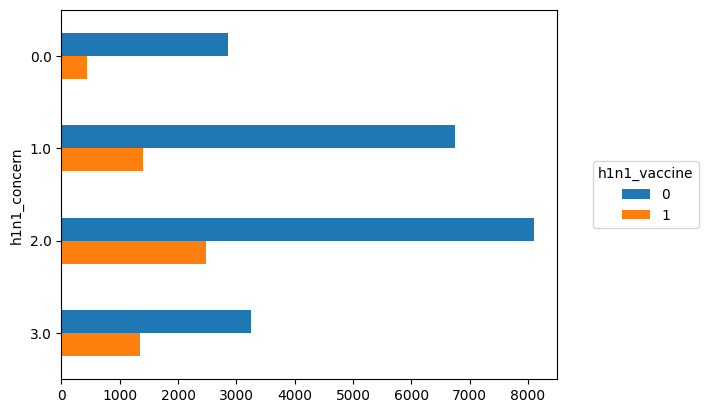

In [39]:
graphA = counts.plot.barh()
graphA.invert_yaxis()
graphA.legend(
    loc='center right',
    bbox_to_anchor=(1.3, 0.5),
    title='h1n1_vaccine'
)


Can't really say that the more concern there is, the more vaccinations, because the (not vaccinated) option is the biggest observation for each concern level.

Maybe we need to look at the rate of vaccination at each concern level, is there a higher rate/chance of vaccination at a higher concern level? Out of the total people at each concern level, what percentage got the vaccine?

In [40]:
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

,0
h1n1_concern,
0.0,3296
1.0,8153
2.0,10575
3.0,4591


In [41]:
percentY = counts.div(h1n1_concern_counts, axis='index')
percentY

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


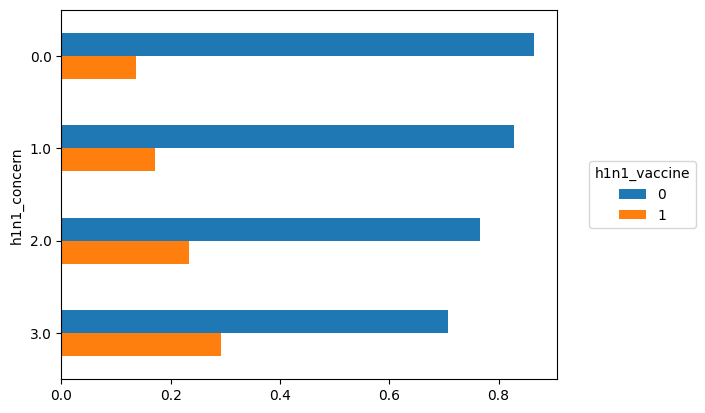

In [42]:
ax = percentY.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In this percentage graph, we can see that as the concern level increases, the percentage of people who got the vaccine also increases and the percentage of people who did not get the vaccine decreases. So, the higher the concern level, the more likely the person would get the H1N1 vaccine.

For the rest of the feature comparisions, we just need to look at the percentage of people who got the vaccine vs not getting the vaccine at each feature -> we can use a stacked bar graph to make this more easier to read.

Make a definition for making the bar graph, so it can be looped through for each feature and each target variable.

In [43]:
def vaccination_rate_plot(col, target, data, ax=None):
    counts = (data[[target, col]].groupby([target, col]).size().unstack(target))
    group_counts = counts.sum(axis='columns')
    percentY = counts.div(group_counts, axis='index')

    percentY.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

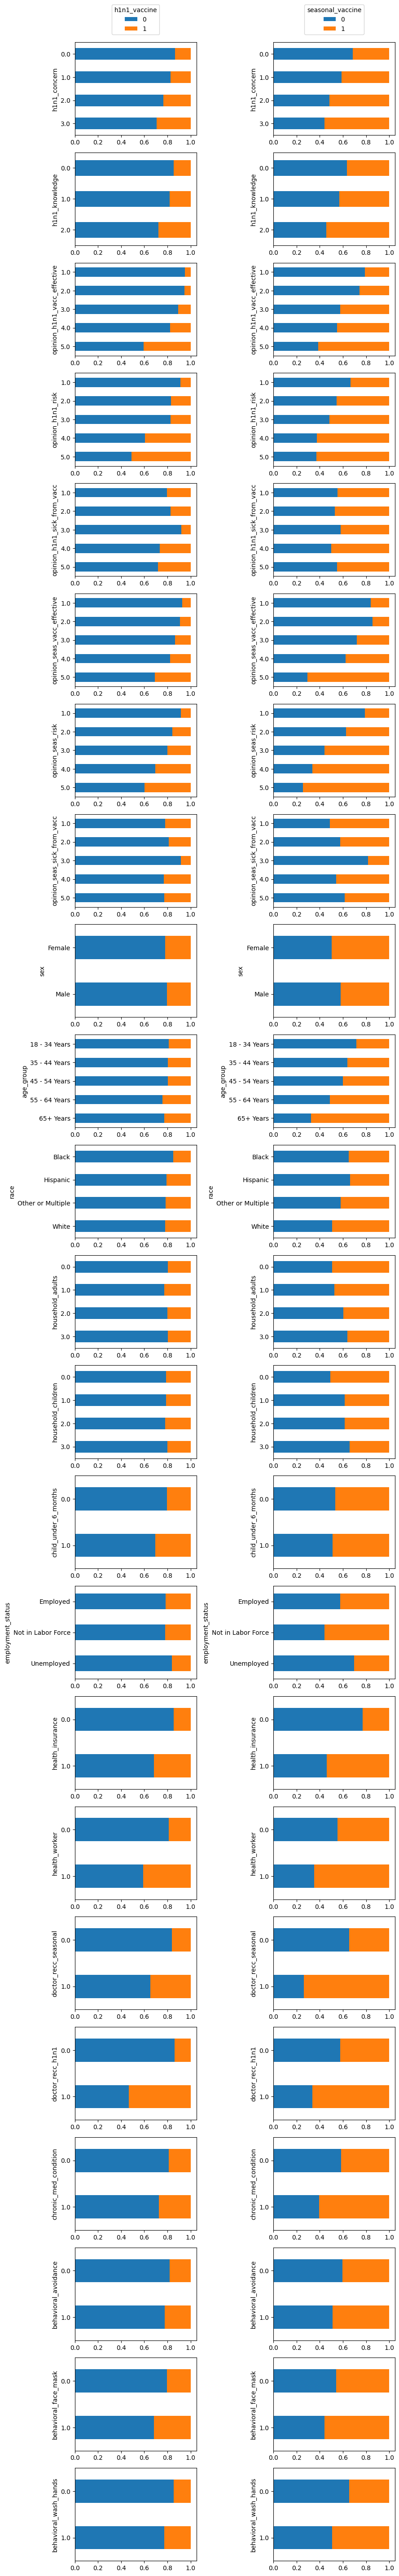

In [44]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
    'household_adults',
    'household_children',
    'child_under_6_months',
    'employment_status',
    'health_insurance',
    'health_worker',
    'doctor_recc_seasonal',
    'doctor_recc_h1n1',
    'chronic_med_condition',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)

for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', data, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', data, ax=ax[idx, 1]
    )

ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

The features asking about knowledge or opinion of the vaccines show good indications for the target variables.

- The more knowledge of H1N1: more vaccinated for H1N1 and seasonal
- H1N1/seasonal effectiveness opinion, think more effective: more percentage vaccinated for H1N1 and seasonal
- The opinion of higher the risk of getting sick from H1N1/seasonal flu without vaccine: more percentage vaccinated for H1N1 and seasonal
- The opinion of more worry of getting sick from the H1N1/seasonal
vaccine: not all that clear cut, though the median worry level from
getting sick from either vaccine has more people not vaccinated compared to the other levels.
- Demographic features show more trends with the seasonal vaccine:
the older the person is, more vaccinated; white and other races, more
vaccinated (outside historical context on race and health: African
Americans are more skeptical of healthcare due to many health tragedies, thus this is understandable); sex of the person, around the same
percentage, with just more female persons having more vaccination.
- Number of adults and children in the house seem to not really
show any trend. However, people with regular contact with children under 6 months are more likely to be vaccinated for H1N1 and seasonal flu.
- Those who have health insurance, are more vaccinated on H1N1 and
seasonal. Those who are healthcare workers, are more vaccinated on both.
- Those who were recommended by their doctor for either H1N1 or
seasonal, are more vaccinated for H1N1 and seasonal. As seen before,
those recommended the seasonal vaccine by their doctor, not many also
vaccinated on H1N1. But those recommended the H1N1 vaccine by their
doctor, many also vaccinated for seasonal flu.
- For the behaviors, the more positive behavior, the more likely to be vaccinated for both overall.
- Those with chronic condition, more likely to be vaccinated on both, more so the seasonal than the H1N1.












# Feature scaling and selection

Need to encode the other data types now for the model building

In [45]:
enc = LabelEncoder()

data.age_group = enc.fit_transform(data.age_group)
data.education = enc.fit_transform(data.education)
data.race = enc.fit_transform(data.race)
data.sex = enc.fit_transform(data.sex)
data.income_poverty = enc.fit_transform(data.income_poverty)
data.employment_status = enc.fit_transform(data.employment_status)

features.age_group = enc.fit_transform(features.age_group)
features.education = enc.fit_transform(features.education)
features.race = enc.fit_transform(features.race)
features.sex = enc.fit_transform(features.sex)
features.income_poverty = enc.fit_transform(features.income_poverty)
features.employment_status = enc.fit_transform(features.employment_status)

In [46]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [47]:
features = pd.DataFrame(features)
col_name = ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation']
features.columns = col_name

In [48]:
X = features
y = labels

Applying SelectKBest class

In [49]:
# Assuming 'seasonal_vaccine' is the target column in your 'labels' DataFrame
y = labels['seasonal_vaccine']

# Create a SimpleImputer to replace NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to your data and transform it
X_imputed = imputer.fit_transform(X)

# Convert the imputed data back to a pandas DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Ensure X_imputed and y have the same number of samples
X_imputed = X_imputed.iloc[:len(y)]  # Trim X_imputed to match y's length

# Now, use the imputed data for feature selection with the single target variable
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X_imputed, y)

In [50]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

print(featureScores.nlargest(25,'Score'))

                          Specs        Score
10         doctor_recc_seasonal  2066.049373
19            opinion_seas_risk  1090.995003
9              doctor_recc_h1n1   695.512437
11        chronic_med_condition   515.154497
21                    age_group   499.304406
16            opinion_h1n1_risk   374.663138
13                health_worker   361.872933
18  opinion_seas_vacc_effective   329.551343
32           household_children   185.052479
8         behavioral_touch_face   123.394755
27                  rent_or_own   113.833924
0                  h1n1_concern   108.507754
15  opinion_h1n1_vacc_effective    97.095665
24                          sex    94.243768
6   behavioral_large_gatherings    69.756457
4          behavioral_face_mask    62.279296
5         behavioral_wash_hands    58.670400
1                h1n1_knowledge    57.835202
7       behavioral_outside_home    50.361891
3          behavioral_avoidance    42.103587
20  opinion_seas_sick_from_vacc    38.564245
14        

In [51]:
features_kbest = features.iloc[:,[9,10,19,16,13,11,21,18,15,34,0,33,32,8,12,1,24,5,26,17,6,3,7,2,4]]

Feature importance using ExtraTrees Classifier

[0.02915134 0.02561249 0.00740794 0.01644545 0.00860229 0.01214234
 0.01755931 0.01768579 0.01669943 0.02368993 0.08411791 0.02051248
 0.01015892 0.01556461 0.02788891 0.03243699 0.03600326 0.02833015
 0.07675067 0.09169632 0.03077984 0.06365193 0.02887302 0.0195639
 0.01931513 0.02572112 0.01941161 0.01804943 0.01635042 0.03564978
 0.02734953 0.02477025 0.02113518 0.02495512 0.02596721]


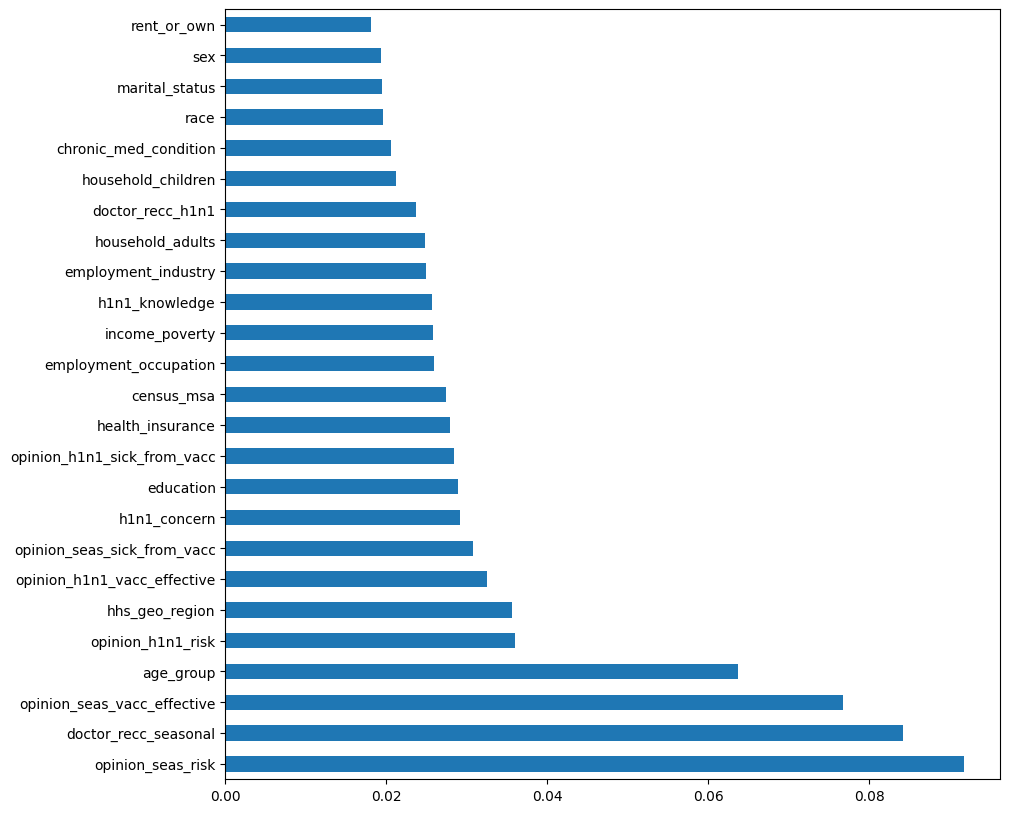

In [52]:
model = ExtraTreesClassifier()
model.fit(X_imputed,y)
print(model.feature_importances_)
plt.figure(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [53]:
features_tree = features.loc[:,['opinion_seas_risk','doctor_recc_seasonal','opinion_seas_vacc_effective',
                                 'doctor_recc_h1n1','age_group','opinion_h1n1_risk','hhs_geo_region',
                                 'opinion_h1n1_vacc_effective','h1n1_concern','opinion_seas_sick_from_vacc',
                                 'opinion_h1n1_sick_from_vacc','census_msa','education','income_poverty',
                                 'h1n1_knowledge','household_adults','employment_occupation',
                                 'employment_industry','household_children','sex','race','marital_status',
                                 'rent_or_own','behavioral_outside_home','behavioral_large_gatherings']]

Correlation Matrix using Heatmap

In [54]:
features.corrwith(labels.h1n1_vaccine)

,0
h1n1_concern,0.121929
h1n1_knowledge,0.117951
behavioral_antiviral_meds,0.040608
behavioral_avoidance,0.047690
behavioral_face_mask,0.070498
behavioral_wash_hands,0.074712
behavioral_large_gatherings,0.017822
behavioral_outside_home,0.021768
behavioral_touch_face,0.071648
doctor_recc_h1n1,0.393890


In [55]:
features.corrwith(labels.seasonal_vaccine)

,0
h1n1_concern,0.154828
h1n1_knowledge,0.120152
behavioral_antiviral_meds,0.006277
behavioral_avoidance,0.076395
behavioral_face_mask,0.050083
behavioral_wash_hands,0.112414
behavioral_large_gatherings,0.064025
behavioral_outside_home,0.053509
behavioral_touch_face,0.120228
doctor_recc_h1n1,0.198607


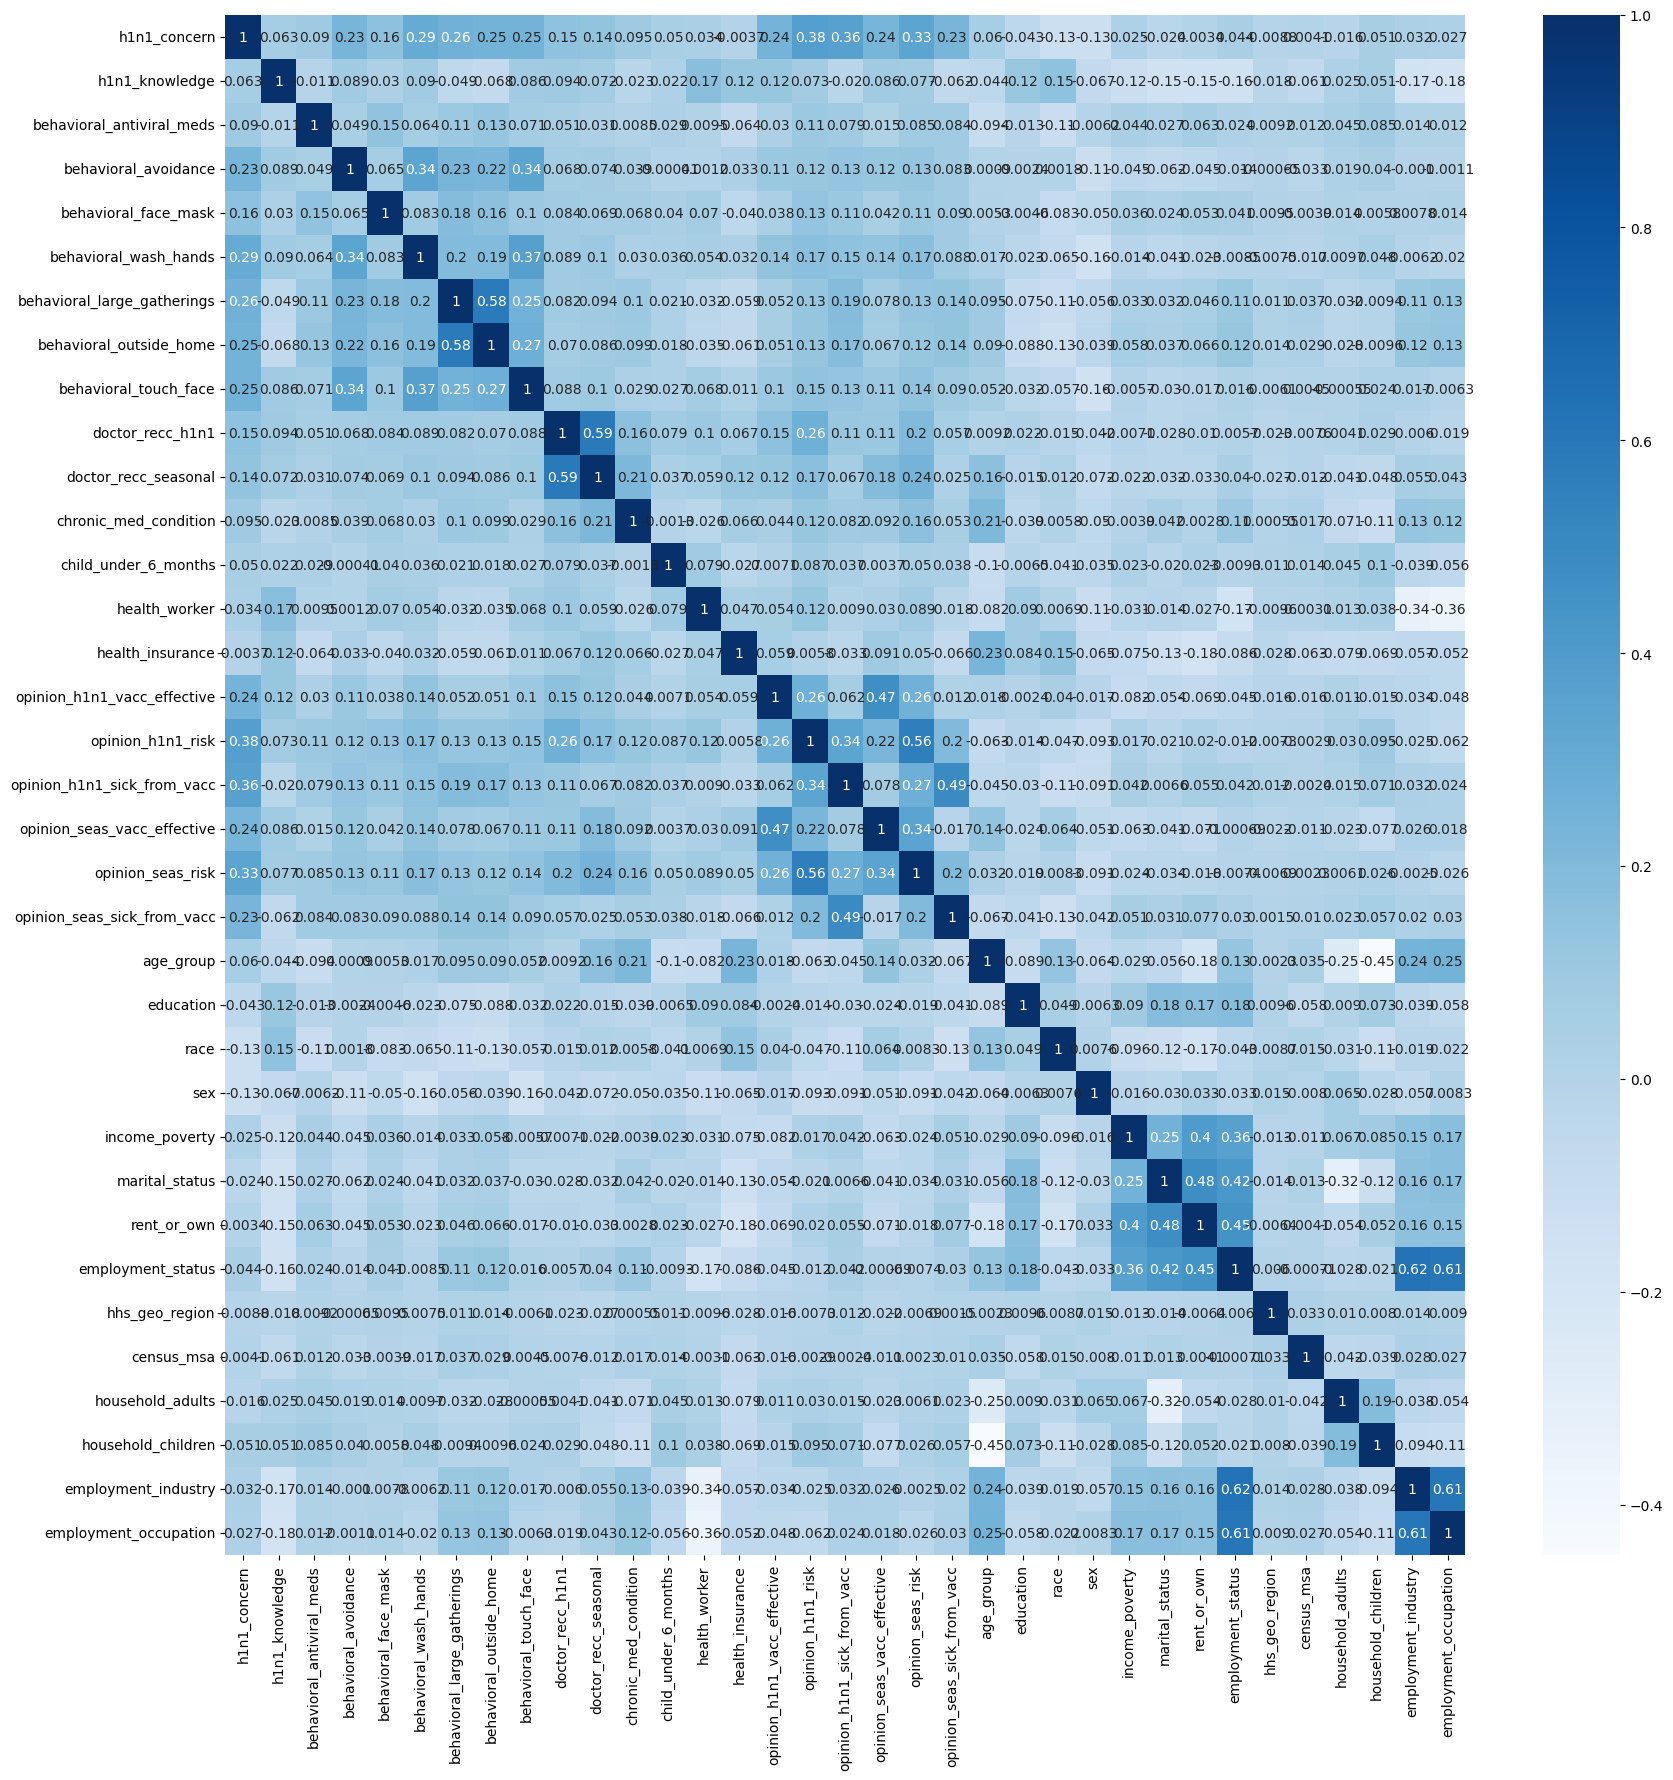

In [56]:
#get correlations of each features in dataset
corrmat = features.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(features[top_corr_features].corr(),annot=True,cmap="Blues")

Encoding using Label encoding to the categorical data

In [57]:
enc = LabelEncoder()
data[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','hhs_geo_region','census_msa'
               ,'employment_industry','employment_occupation']] = data[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','hhs_geo_region','census_msa'
               ,'employment_industry','employment_occupation']].apply(enc.fit_transform)

data[['age_group','education','race','sex','income_poverty','marital_status','rent_or_own','employment_status','hhs_geo_region','census_msa'
               ,'employment_industry','employment_occupation']]

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,3,1,3,0,2,1,0,1,8,2,21,23
1,1,0,3,1,2,1,1,0,1,0,12,19
2,0,2,3,1,0,1,0,0,9,0,14,21
3,4,0,3,0,2,1,1,1,5,1,21,23
4,2,3,3,0,0,0,0,0,9,0,18,5
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,4,3,3,0,0,1,0,1,9,2,21,23
26703,0,2,3,1,0,1,1,0,6,1,4,2
26704,3,3,3,0,3,1,0,3,6,0,21,23


# Model: building/selection - training and validation - make prediction

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # To use with SMOTE

Model Creation

### **Logistic Regression**

In [59]:
h1n1_target = labels['h1n1_vaccine']
seasonal_target = labels['seasonal_vaccine']
categorical_features = features.columns  # Assuming all features are categorical

One-hot encode categorical features' variables into a more ML-friendly form.

In [60]:
# Preprocessing for categorical data including binary
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding for all features
])

# Preprocessor for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])



In [61]:
# Building the pipeline for h1n1 vaccine prediction with preprocessing and class imbalance handling
pipeline_h1n1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(sampling_strategy='auto', random_state=42)),  # Handle class imbalance
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))  # Logistic regression classifier
])

# Building the pipeline for seasonal vaccine prediction with preprocessing
pipeline_seasonal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))  # Logistic regression classifier
])

Dataset split into training and validation for model training and validation of the performance. Can check beforehand how the model will do with the test set.

In [62]:
# Splitting the dataset into training and validation sets
X_train, X_val, y_train_h1n1, y_val_h1n1, y_train_seasonal, y_val_seasonal = train_test_split(
    features, h1n1_target, seasonal_target, test_size=0.2, random_state=42)

In [63]:
# Fitting the models
pipeline_h1n1.fit(X_train, y_train_h1n1)
pipeline_seasonal.fit(X_train, y_train_seasonal)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_...
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [64]:
# Making predictions (probabilities) on the validation set
probabilities_h1n1 = pipeline_h1n1.predict_proba(X_val)[:, 1]  # Probabilities for the positive class
probabilities_seasonal = pipeline_seasonal.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

# Evaluating the models using ROC-AUC
roc_auc_h1n1 = roc_auc_score(y_val_h1n1, probabilities_h1n1)
roc_auc_seasonal = roc_auc_score(y_val_seasonal, probabilities_seasonal)

print(f"ROC-AUC for H1N1 Vaccine Prediction: {roc_auc_h1n1}")
print(f"ROC-AUC for Seasonal Vaccine Prediction: {roc_auc_seasonal}")

ROC-AUC for H1N1 Vaccine Prediction: 0.8614374017766347
ROC-AUC for Seasonal Vaccine Prediction: 0.8608231542310928


The `ROC-AUC` metric used to evaluate model performance on the validation set. `ROC-AUC` can handle imbalanced classes. The model is performing well, but not all the way up to .90.

**Make prediction on Test Set**

In [65]:
# load the test set into a data frame
test_set_features = pd.read_csv('/content/test_set_features.csv', index_col="respondent_id")

In [66]:
# Making predictions on the test set for both h1n1 and seasonal vaccines
probabilities_h1n1_test = pipeline_h1n1.predict_proba(test_set_features)[:, 1]  # Probabilities for h1n1_vaccine
probabilities_seasonal_test = pipeline_seasonal.predict_proba(test_set_features)[:, 1]  # Probabilities for seasonal_vaccine

In [67]:
# Prepare submission DataFrame with current date
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d")
submission_df = pd.DataFrame({
    "respondent_id": test_set_features.index,
    "h1n1_vaccine": probabilities_h1n1_test,
    "seasonal_vaccine": probabilities_seasonal_test
})
submission_file_path = f"/content/submission_{current_date}.csv"
submission_df.to_csv(submission_file_path, index=False)
print(f"Submission file with {submission_df.shape[0]} rows saved to {submission_file_path}")

Submission file with 26708 rows saved to /content/submission_2024-11-16.csv


In [69]:
logSub = pd.read_csv('/content/submission_2024-11-16.csv')
logSub.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.706087,0.416778
1,26708,0.601411,0.275099
2,26709,0.152775,0.227048
3,26710,0.876812,0.622069
4,26711,0.697789,0.467149


Save the models made for later use

In [70]:
# Import the joblib library
import joblib

# Save models to files
model_path_h1n1 = "/content/pipeline_h1n1.joblib"
model_path_seasonal = "/content/pipeline_seasonal.joblib"
joblib.dump(pipeline_h1n1, model_path_h1n1)
joblib.dump(pipeline_seasonal, model_path_seasonal)
print(f"Model saved to {model_path_h1n1}")
print(f"Model saved to {model_path_seasonal}")

Model saved to /content/pipeline_h1n1.joblib
Model saved to /content/pipeline_seasonal.joblib


### Using Binary Relevance

X_train, X_val, y_train_h1n1, y_val_h1n1, y_train_seasonal, y_val_seasonal = train_test_split(
    features, h1n1_target, seasonal_target, test_size=0.2, random_state=42)

In [71]:
x=data.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
y=data[['h1n1_vaccine','seasonal_vaccine']]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((5341, 35), (21366, 35), (5341, 2), (21366, 2))

In [73]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [74]:
# Import the necessary classes from tensorflow.keras.layers
from tensorflow.keras.layers import Input, Dense # Import Dense

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# Hidden layers
hidden_layer1 = Dense(64, activation='relu')(input_layer)
hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)

# Output layer for H1N1 vaccine
output_layer_h1n1 = Dense(1, activation='sigmoid', name='h1n1_vaccine')(hidden_layer2)

# Output layer for Seasonal vaccine
output_layer_seasonal = Dense(1, activation='sigmoid', name='seasonal_vaccine')(hidden_layer2)

# Create the model
from tensorflow.keras.models import Model # Import Model if not already imported
model = Model(inputs=input_layer, outputs=[output_layer_h1n1, output_layer_seasonal])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
# Convert Our Multi-Label Prob to Multi-Class
# binary classficiation
binary_rel_clf = BinaryRelevance(MultinomialNB())
#binary_rel_clf2 = BinaryRelevance(MultinomialNB())

Logistic Regression

In [76]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[['accuracy'], ['accuracy']]  # Provide a list of metrics for each output
)

model.fit(
    X_train,
    [y_train['h1n1_vaccine'], y_train['seasonal_vaccine']],
    epochs=10,
    batch_size=32,
    validation_split=0.2,
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - h1n1_vaccine_accuracy: 0.8091 - h1n1_vaccine_loss: nan - loss: nan - seasonal_vaccine_accuracy: 0.5498 - seasonal_vaccine_loss: nan - val_h1n1_vaccine_accuracy: 0.8129 - val_h1n1_vaccine_loss: nan - val_loss: nan - val_seasonal_vaccine_accuracy: 0.5744 - val_seasonal_vaccine_loss: nan
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - h1n1_vaccine_accuracy: 0.7801 - h1n1_vaccine_loss: nan - loss: nan - seasonal_vaccine_accuracy: 0.5378 - seasonal_vaccine_loss: nan - val_h1n1_vaccine_accuracy: 0.8129 - val_h1n1_vaccine_loss: nan - val_loss: nan - val_seasonal_vaccine_accuracy: 0.5744 - val_seasonal_vaccine_loss: nan
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - h1n1_vaccine_accuracy: 0.7912 - h1n1_vaccine_loss: nan - loss: nan - seasonal_vaccine_accuracy: 0.5382 - seasonal_vaccine_loss: nan - val_h1n1_vaccine_accuracy: 0.8129 - val_h1n1_vaccine_loss: nan - val_loss: nan - val_seasonal_vaccine_accuracy: 0.5744 - val_seasona

Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Step 3: Train a Random Forest classifier for h1n1_vaccine
model_h1n1_rf = RandomForestClassifier()
model_h1n1_rf.fit(X_train, y_train['h1n1_vaccine'])

# Step 3: Train a Random Forest classifier for seasonal_vaccine
model_seasonal_rf = RandomForestClassifier()
model_seasonal_rf.fit(X_train, y_train['seasonal_vaccine'])

# Step 4: Make predictions on the test data
y_pred_h1n1_rf = model_h1n1_rf.predict(X_test)
y_pred_seasonal_rf = model_seasonal_rf.predict(X_test)

# Step 5: Calculate and print accuracy, precision, and recall for h1n1_vaccine
accuracy_h1n1_rf = accuracy_score(y_test['h1n1_vaccine'], y_pred_h1n1_rf)
precision_h1n1_rf = precision_score(y_test['h1n1_vaccine'], y_pred_h1n1_rf)
recall_h1n1_rf = recall_score(y_test['h1n1_vaccine'], y_pred_h1n1_rf)

print("h1n1_vaccine Random Forest Metrics:")
print("Accuracy:", accuracy_h1n1_rf)
print("Precision:", precision_h1n1_rf)
print("Recall:", recall_h1n1_rf)

# Step 5: Calculate and print accuracy, precision, and recall for seasonal_vaccine
accuracy_seasonal_rf = accuracy_score(y_test['seasonal_vaccine'], y_pred_seasonal_rf)
precision_seasonal_rf = precision_score(y_test['seasonal_vaccine'], y_pred_seasonal_rf)
recall_seasonal_rf = recall_score(y_test['seasonal_vaccine'], y_pred_seasonal_rf)

print("\nseasonal_vaccine Random Forest Metrics:")
print("Accuracy:", accuracy_seasonal_rf)
print("Precision:", precision_seasonal_rf)
print("Recall:", recall_seasonal_rf)

h1n1_vaccine Random Forest Metrics:
Accuracy: 0.8437236731255265
Precision: 0.7700084245998315
Recall: 0.39558537113178965

seasonal_vaccine Random Forest Metrics:
Accuracy: 0.7729570345408593
Precision: 0.7785675821217016
Recall: 0.721169193934557
